# Introduction

This notebook analysis the sourcetypes to get a better overview of the dataset

# Notebook setup

In [45]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 0)

from splunkconnector import core
# from https://github.com/ogrodas/splunk_connector

s=core.SplunkConnect("https://localhost:8089")
s.auth("admin","superadmin")
SPL=s.read_pandas

# Dataset overview

SPL query to get basic statistics on the dataset by sourcetype

In [4]:
%%time
sourcetypes=SPL("search index=botsv2 | stats count by sourcetype | sort -count")

CPU times: user 407 ms, sys: 21.5 ms, total: 428 ms
Wall time: 2min 49s


Number of events

In [5]:
sourcetypes["count"].sum()

71230176

Number of sourcetypes

In [6]:
len(sourcetypes)

100

Size of botsv2 index in splunk


In [38]:
SPL("| rest /services/data/indexes | stats values(currentDBSizeMB) by title | search title=botsv2")

,title,values(currentDBSizeMB)
0,botsv2,5545


There are 100 sourceypes and about 71 million events. The size of the splunk index is X Mb.  The dataset is to big to go through every event manually but it is small enough that is is quite fast to run queries against it on a single test computer. Running the stats command above probably forces splunk to read every event and takes about 2min og 50 sec on my computer which is acceptable delay for testing

It can be difficult to get an overview of the data when there are 100 sourcetypes. To get more details we use the query below:

In [7]:
stats=SPL("""
 |metadata type=sourcetypes index="botsv2" 
 | join type=left sourcetype [
     | rest /services/saved/sourcetypes 
     | rename title AS sourcetype, "eai:acl.app" AS app
     | table  sourcetype, app, category, description
 ] 
 | fields sourcetype, app, category, description, firstTime,lastTime, totalCount
 | eval firstTime=strftime(firstTime,"%d/%m/%y %H:%M:%S"), lastTime=strftime(lastTime,"%d/%m/%y %H:%M:%S")
 | sort app_name
""")

In [8]:
stats

,sourcetype,app,category,description,firstTime,lastTime,totalCount,_timediff
0,ActiveDirectory,Splunk_TA_windows,NaN,NaN,19/08/17 05:14:43,29/08/17 10:14:58,13,NaN
1,Linux:SELinuxConfig,Splunk_TA_nix,NaN,NaN,08/08/17 13:59:59,29/08/17 10:30:39,52,NaN
2,MSAD:NT6:Health,Splunk_TA_windows,NaN,NaN,03/08/17 18:07:54,29/08/17 11:11:32,345,NaN
3,MSAD:NT6:SiteInfo,Splunk_TA_windows,NaN,NaN,03/08/17 18:15:35,29/08/17 10:15:01,118,NaN
4,Perfmon:CPU,Splunk_TA_windows,NaN,NaN,03/08/17 18:00:46,29/08/17 11:11:39,392766,NaN
5,Perfmon:LogicalDisk,Splunk_TA_windows,NaN,NaN,03/08/17 18:00:25,29/08/17 11:11:23,576000,NaN
6,Perfmon:Memory,Splunk_TA_windows,NaN,NaN,03/08/17 18:00:26,29/08/17 11:11:38,423658,NaN
7,Perfmon:NTDS,Splunk_TA_windows,NaN,NaN,03/08/17 18:02:34,29/08/17 11:11:14,120307,NaN
8,Perfmon:Network,Splunk_TA_windows,NaN,NaN,03/08/17 18:00:27,29/08/17 11:11:22,149471,NaN
9,Perfmon:Network_Interface,Splunk_TA_windows,NaN,NaN,03/08/17 18:02:34,29/08/17 11:11:33,90990,NaN


Number of sourcetypes per app

In [9]:
stats.groupby("app")["app"].count().sort_values(ascending=False)

app
Splunk_TA_windows                    22
Splunk_TA_nix                        20
Splunk_TA_symantec-ep                8 
Splunk_TA_stream                     8 
system                               3 
botsv2_data_set                      3 
Splunk_TA_paloalto                   3 
TA-microsoft-sysmon                  1 
TA-Suricata                          1 
Splunk_TA_microsoft-cloudservices    1 
Name: app, dtype: int64

Number of events per app

In [10]:
stats.groupby("app")["totalCount"].sum().sort_values(ascending=False)

app
Splunk_TA_windows                    25809132
Splunk_TA_stream                     1453846 
Splunk_TA_paloalto                   420968  
system                               325530  
TA-Suricata                          325191  
Splunk_TA_nix                        267209  
TA-microsoft-sysmon                  205275  
botsv2_data_set                      127158  
Splunk_TA_symantec-ep                57710   
Splunk_TA_microsoft-cloudservices    4480    
Name: totalCount, dtype: int64

First and last event i data set:

In [47]:
first_last=SPL("""
index=botsv2 
| stats earliest(_time) as first ,latest(_time) as last
| eval first=strftime(first,"%d/%m/%y %H:%M:%S"), last=strftime(last,"%d/%m/%y %H:%M:%S")
""")

In [48]:
first_last

,first,last
0,02/08/17 18:03:26,31/08/17 03:17:11



Overview of events by time. 
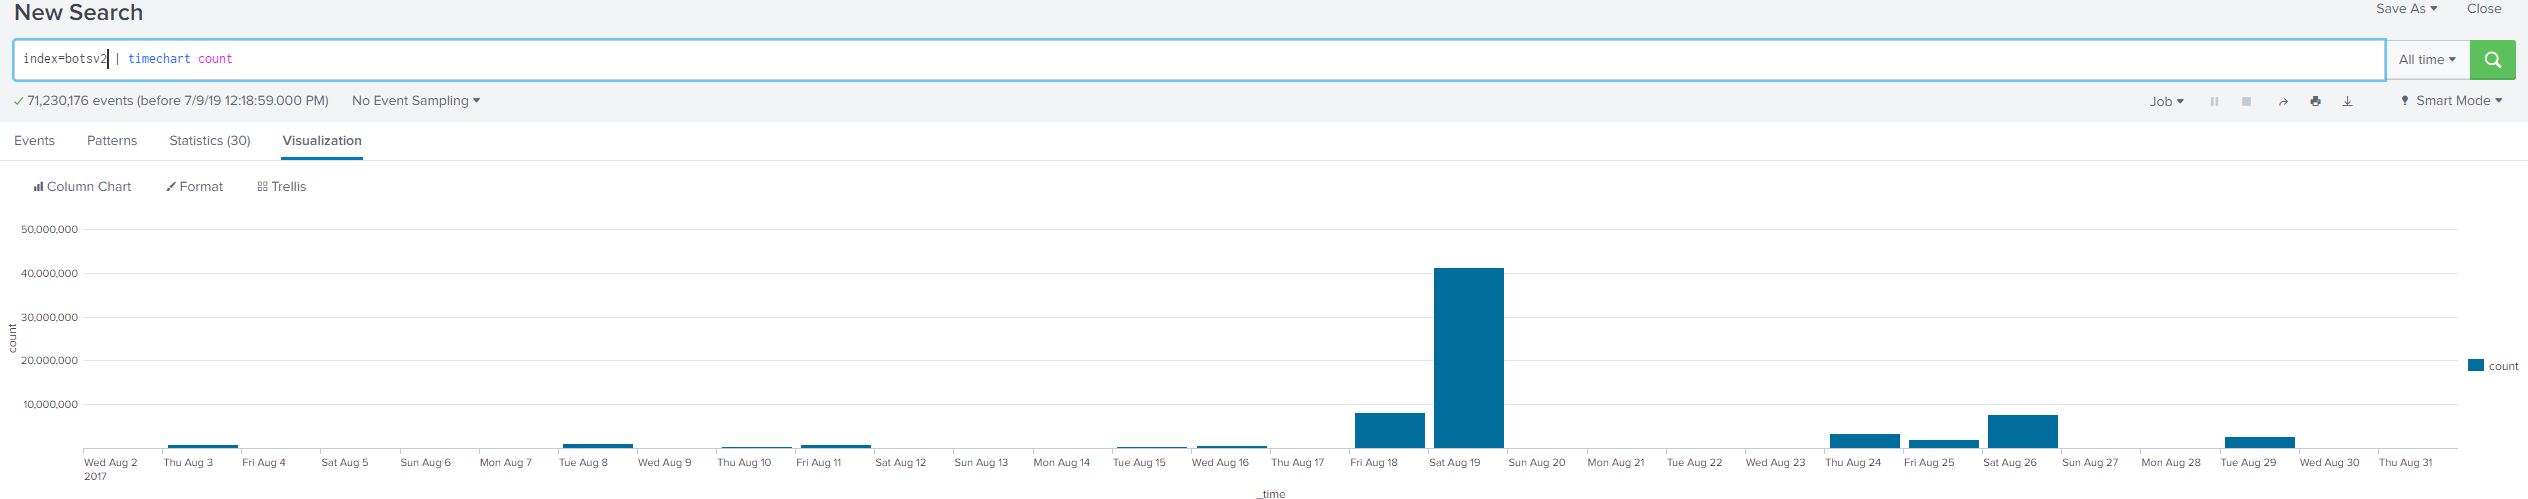

The first event is 2.august and the last event is 31.august 2017. All activity is therefor within one month in 2017. 

Aug 19 is clearly the day with the most activity. There is also some activity the 18.august. The next cluster of activity is 24-26.august.

18-19 august is a friday and saturday and 24-26 august is a thursday to saturday. Seems like creating the dataset was an end of week activity


# Detailed sourcetype walk through

In [11]:
stats["cat2"]=""

## Symantec Endpoint Protection(SEP)

I'm expecting the SEP sourcetypes to contain high fidelity event that can be important trigger information for threat hunting. 

* Disabling of SEP. Some attackers disable antivirus. 
* Malware or other threats detected by SEP

There is in total 57710 alarms from SEP.


In [12]:
stats.loc[stats.app=="Splunk_TA_symantec-ep","cat2"]="symantec"
stats[stats.cat2=="symantec"]

,sourcetype,app,category,description,firstTime,lastTime,totalCount,_timediff,cat2
87,symantec:ep:agent:file,Splunk_TA_symantec-ep,Network & Security,Symantec Endpoint Protection server client agent events,03/08/17 18:01:38,29/08/17 11:10:28,2784,NaN,symantec
88,symantec:ep:agt_system:file,Splunk_TA_symantec-ep,Network & Security,Symantec Endpoint Protection client agent system events,03/08/17 17:57:16,29/08/17 11:02:34,8900,NaN,symantec
89,symantec:ep:behavior:file,Splunk_TA_symantec-ep,Network & Security,Symantec Endpoint Protection agent behavior events,27/08/17 23:28:24,27/08/17 23:28:24,1,NaN,symantec
90,symantec:ep:packet:file,Splunk_TA_symantec-ep,Network & Security,Symantec Endpoint Protection client packet events,03/08/17 17:34:05,29/08/17 11:01:58,38377,NaN,symantec
91,symantec:ep:scan:file,Splunk_TA_symantec-ep,Network & Security,Symantec Endpoint Protection agent scan events,08/08/17 13:41:37,29/08/17 10:15:36,30,NaN,symantec
92,symantec:ep:scm_system:file,Splunk_TA_symantec-ep,Network & Security,Symantec Endpoint Protection server system events,03/08/17 18:09:14,29/08/17 10:44:57,357,NaN,symantec
93,symantec:ep:security:file,Splunk_TA_symantec-ep,Network & Security,Symantec Endpoint Protection agent security events,29/08/17 10:23:50,29/08/17 10:23:50,1,NaN,symantec
94,symantec:ep:traffic:file,Splunk_TA_symantec-ep,Network & Security,Symantec Endpoint Protection agent traffic events,03/08/17 17:54:49,29/08/17 11:02:00,7260,NaN,symantec


In [13]:
stats[stats.cat2=="symantec"]["totalCount"].sum()

57710

## TA Windows++

There are a lot of different logs form windows systems. There are 23 different sourcetypes and in total 26 million events. I don't except there to be easily identified high fidelity event in this group, but I do except there is a lot of import information given good threat hunting searches. I assume that using for example rules from the Sigma project it will be possible to detect attacks with these events

In [51]:
stats.loc[stats.app.str.contains("Splunk_TA_windows|TA-microsoft-sysmon").fillna(False),"cat2"]="windows"
stats[stats.cat2=="windows"].sort_values(by="sourcetype")

,sourcetype,app,category,description,firstTime,lastTime,totalCount,_timediff,cat2
0,ActiveDirectory,Splunk_TA_windows,NaN,NaN,19/08/17 05:14:43,29/08/17 10:14:58,13,NaN,windows
2,MSAD:NT6:Health,Splunk_TA_windows,NaN,NaN,03/08/17 18:07:54,29/08/17 11:11:32,345,NaN,windows
3,MSAD:NT6:SiteInfo,Splunk_TA_windows,NaN,NaN,03/08/17 18:15:35,29/08/17 10:15:01,118,NaN,windows
4,Perfmon:CPU,Splunk_TA_windows,NaN,NaN,03/08/17 18:00:46,29/08/17 11:11:39,392766,NaN,windows
5,Perfmon:LogicalDisk,Splunk_TA_windows,NaN,NaN,03/08/17 18:00:25,29/08/17 11:11:23,576000,NaN,windows
6,Perfmon:Memory,Splunk_TA_windows,NaN,NaN,03/08/17 18:00:26,29/08/17 11:11:38,423658,NaN,windows
7,Perfmon:NTDS,Splunk_TA_windows,NaN,NaN,03/08/17 18:02:34,29/08/17 11:11:14,120307,NaN,windows
8,Perfmon:Network,Splunk_TA_windows,NaN,NaN,03/08/17 18:00:27,29/08/17 11:11:22,149471,NaN,windows
9,Perfmon:Network_Interface,Splunk_TA_windows,NaN,NaN,03/08/17 18:02:34,29/08/17 11:11:33,90990,NaN,windows
10,Perfmon:PhysicalDisk,Splunk_TA_windows,NaN,NaN,03/08/17 18:00:25,29/08/17 11:11:23,478753,NaN,windows


In [15]:
stats[stats.cat2=="windows"]["totalCount"].sum()

26014407

In [16]:
stats[stats.cat2=="windows"]["totalCount"].count()

23

## TA_nix++

Compared to windows there are more sourcetypes and less alarms with 28 sourcetypes but only 880 000 events

In [52]:
stats.loc[(stats.app=="Splunk_TA_nix")|  stats.sourcetype.str.contains("Unix|audit|linux"),"cat2"]="linux"
stats[stats.cat2=="linux"].sort_values(by="sourcetype")

,sourcetype,app,category,description,firstTime,lastTime,totalCount,_timediff,cat2
1,Linux:SELinuxConfig,Splunk_TA_nix,NaN,NaN,08/08/17 13:59:59,29/08/17 10:30:39,52,NaN,linux
17,Unix:ListeningPorts,NaN,NaN,NaN,08/08/17 13:59:59,29/08/17 10:34:17,1409,NaN,linux
18,Unix:Service,NaN,NaN,NaN,18/08/17 21:25:32,29/08/17 10:34:17,29,NaN,linux
19,Unix:Update,NaN,NaN,NaN,18/08/17 21:25:31,18/08/17 21:25:31,1,NaN,linux
20,Unix:Uptime,NaN,NaN,NaN,18/08/17 21:25:31,18/08/17 21:25:31,1,NaN,linux
21,Unix:UserAccounts,NaN,NaN,NaN,08/08/17 13:59:59,29/08/17 10:34:17,3865,NaN,linux
22,Unix:Version,NaN,NaN,NaN,18/08/17 21:25:32,19/08/17 01:30:00,2,NaN,linux
34,auditd,NaN,NaN,NaN,03/08/17 18:02:31,29/08/17 11:11:31,303326,NaN,linux
35,bandwidth,Splunk_TA_nix,NaN,NaN,03/08/17 18:03:14,29/08/17 11:11:15,2109,NaN,linux
37,cpu,Splunk_TA_nix,NaN,NaN,03/08/17 18:03:14,29/08/17 11:11:44,4220,NaN,linux


In [18]:
stats[stats.cat2=="linux"]["totalCount"].sum()

880424

In [19]:
stats[stats.cat2=="linux"]["totalCount"].count()

28

## Mysql

In [20]:
stats.loc[stats.sourcetype.str.startswith("mysql"),"cat2"]="mysql"
stats[stats.cat2=="mysql"]

,sourcetype,app,category,description,firstTime,lastTime,totalCount,_timediff,cat2
48,mysql:connection:stats,NaN,NaN,NaN,03/08/17 18:01:45,29/08/17 11:10:49,5352,NaN,mysql
49,mysql:database,NaN,NaN,NaN,03/08/17 18:04:37,29/08/17 10:23:13,106,NaN,mysql
50,mysql:errorLog,NaN,NaN,NaN,03/08/17 18:03:26,29/08/17 10:21:59,98,NaN,mysql
51,mysql:instance:stats,NaN,NaN,NaN,03/08/17 18:04:42,29/08/17 11:09:46,2111,NaN,mysql
52,mysql:server:stats,NaN,NaN,NaN,03/08/17 18:01:45,29/08/17 11:10:50,13579885,NaN,mysql
53,mysql:status,NaN,NaN,NaN,03/08/17 18:04:43,29/08/17 11:10:49,557023,NaN,mysql
54,mysql:tableStatus,NaN,NaN,NaN,03/08/17 18:04:41,29/08/17 10:23:16,25086,NaN,mysql
55,mysql:table_io_waits_summary_by_index_usage,NaN,NaN,NaN,03/08/17 18:04:40,29/08/17 11:06:52,314,NaN,mysql
56,mysql:transaction:details,NaN,NaN,NaN,03/08/17 18:04:44,29/08/17 11:10:50,13574451,NaN,mysql
57,mysql:transaction:stats,NaN,NaN,NaN,03/08/17 18:01:45,29/08/17 11:10:49,5352,NaN,mysql


## Splunk stream

In [21]:
stats.loc[stats.sourcetype.str.startswith("stream"),"cat2"]="stream"
stats[stats.cat2=="stream"]

,sourcetype,app,category,description,firstTime,lastTime,totalCount,_timediff,cat2
72,stream:arp,NaN,NaN,NaN,03/08/17 18:02:03,29/08/17 11:13:01,106326,NaN,stream
73,stream:dhcp,Splunk_TA_stream,NaN,NaN,03/08/17 18:02:59,29/08/17 11:09:43,10165,NaN,stream
74,stream:dns,Splunk_TA_stream,NaN,NaN,03/08/17 18:02:17,29/08/17 11:12:01,185160,NaN,stream
75,stream:ftp,Splunk_TA_stream,NaN,NaN,24/08/17 03:36:14,26/08/17 06:45:35,1490,NaN,stream
76,stream:http,Splunk_TA_stream,NaN,NaN,03/08/17 07:02:57,31/08/17 03:17:11,104209,NaN,stream
77,stream:icmp,NaN,NaN,NaN,03/08/17 18:02:03,29/08/17 11:07:44,94869,NaN,stream
78,stream:ip,NaN,NaN,NaN,03/08/17 17:15:02,29/08/17 11:12:01,415277,NaN,stream
79,stream:irc,NaN,NaN,NaN,26/08/17 05:42:59,26/08/17 05:42:59,1,NaN,stream
80,stream:ldap,NaN,NaN,NaN,03/08/17 18:02:30,29/08/17 11:08:47,14868,NaN,stream
81,stream:mysql,Splunk_TA_stream,NaN,NaN,03/08/17 18:00:13,29/08/17 11:10:55,151867,NaN,stream


## PAN - Palo Alto Networks

In [22]:
stats.loc[stats.sourcetype.str.startswith("pan"),"cat2"]="paloalto"
stats[stats.cat2=="paloalto"]

,sourcetype,app,category,description,firstTime,lastTime,totalCount,_timediff,cat2
67,pan:system,Splunk_TA_paloalto,NaN,NaN,03/08/17 18:02:53,29/08/17 11:11:20,6004,NaN,paloalto
68,pan:threat,Splunk_TA_paloalto,NaN,NaN,26/08/17 06:24:10,26/08/17 06:46:14,2,NaN,paloalto
69,pan:traffic,Splunk_TA_paloalto,NaN,NaN,03/08/17 18:02:32,29/08/17 11:11:37,414962,NaN,paloalto


## OSquery

In [23]:
stats.loc[stats.sourcetype.str.startswith("osquery"),"cat2"]="osquery"
stats[stats.cat2=="osquery"]

,sourcetype,app,category,description,firstTime,lastTime,totalCount,_timediff,cat2
63,osquery_info,NaN,NaN,NaN,03/08/17 18:02:35,29/08/17 11:11:38,8504,NaN,osquery
64,osquery_results,botsv2_data_set,NaN,NaN,03/08/17 18:04:27,29/08/17 11:10:15,13884,NaN,osquery
65,osquery_warning,NaN,NaN,NaN,03/08/17 18:08:55,29/08/17 11:03:43,137,NaN,osquery


## Suricata

I except suricata to contain import alarms but also contain a lot of false positives. There are 325 000 suricata events which also indicates a high False positive rate(FPR)

In [24]:
stats.loc[stats.sourcetype.str.startswith("suricata"),"cat2"]="suricata"
stats[stats.cat2=="suricata"]

,sourcetype,app,category,description,firstTime,lastTime,totalCount,_timediff,cat2
86,suricata,TA-Suricata,NaN,NaN,03/08/17 18:02:02,29/08/17 11:11:07,325191,NaN,suricata


## WEB

In [25]:
stats.loc[stats.sourcetype.str.contains("apache|[Ww]eb[Ll]ogic|csp-violation|access"),"cat2"]="web"
stats[stats.cat2=="web"]

,sourcetype,app,category,description,firstTime,lastTime,totalCount,_timediff,cat2
23,WebLogic_Access_Combined,NaN,NaN,NaN,23/08/17 22:07:40,24/08/17 23:07:24,59359,NaN,web
32,access_combined,botsv2_data_set,Web,National Center for Supercomputing Applications (NCSA) combined format HTTP web server logs (can be generated by apache or other web servers),03/08/17 18:03:23,29/08/17 11:11:36,10588,NaN,web
33,apache_error,system,Web,Error log format produced by the Apache web server (typically error_log on *nix systems),05/08/17 08:15:15,24/08/17 04:26:15,4169,NaN,web
38,csp-violation,NaN,NaN,NaN,05/08/17 08:17:34,16/08/17 15:19:38,89,NaN,web
101,weblogic_stdout,system,Application,Output produced by the Oracle WebLogic Java EE application server,03/08/17 18:03:22,29/08/17 11:07:51,16779,NaN,web


## Cloud

In [26]:
stats.loc[stats.app=="Splunk_TA_microsoft-cloudservices","cat2"]="cloud"
stats[stats.cat2=="cloud"]

,sourcetype,app,category,description,firstTime,lastTime,totalCount,_timediff,cat2
47,ms:o365:management,Splunk_TA_microsoft-cloudservices,Application,"""Microsoft Cloud Services""",02/08/17 18:03:26,28/08/17 11:10:24,4480,NaN,cloud


## Other sourcetypes

In [27]:
stats[stats.cat2==""]

,sourcetype,app,category,description,firstTime,lastTime,totalCount,_timediff,cat2
14,Powershell:ScriptExecutionSummary,NaN,NaN,NaN,03/08/17 18:15:02,29/08/17 10:15:01,99,NaN,
36,collectd,NaN,NaN,NaN,03/08/17 18:03:17,29/08/17 11:11:34,10326926,NaN,
40,ess_content_importer,NaN,NaN,NaN,03/08/17 18:24:16,29/08/17 11:12:47,31,NaN,
100,web_ping,NaN,NaN,NaN,03/08/17 18:03:23,29/08/17 11:11:18,1869,NaN,
